In [68]:
import pandas as pd
import numpy as np
import re
import time
from kiwipiepy import Kiwi
import tomotopy as tp
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import array_contains, udf
from datetime import datetime
# Word2Vec embedding
from gensim.models import Word2Vec
from numpy import dot
from numpy.linalg import norm
import numpy as np
from sklearn.cluster import KMeans
from textrank import KeywordSummarizer

#################################################################

def insta_preporcessing(insta):

    # 데이터 로드
    insta_data = pd.read_csv(insta)

    # 1차 클린징(영어, 특수문자, 숫자제거)
    for i in range(len(insta_data.content)):
        insta_data.content[i] = sub_special(insta_data.content[i])

    # 토큰화
    for i in range(len(insta_data.content)):
        insta_data.content[i]= tokenize(insta_data.content[i])

    # 2차 클린징(불용어 처리)
        word_cleansing(insta_data)

    return insta_data


def naver_preprocessing(naver):

    #데이터 로드
    naver_data = pd.read_csv(naver)

    # 인덱스 제거
    naver_data.drop('Unnamed: 0', axis=1, inplace=True)

    # 토큰화
    for i in range(len(naver_data)):
        naver_data.content[i] = sub_special_token(naver_data.content[i])

    #클린징
    word_cleansing(naver_data)

    return naver_data

def make_stopwords(input_text):
    with open (input_text, 'r', encoding= 'utf-8') as f:
        words = f.readline().split()
    stop_words = '의 가 이 은 들 는 좀 잘 속초 걍 과 했 거 해서 게 찍 느낌 많이 듯 뷰 박 링크 인스타그램 할인 성수기 홈페이지 주말 블로그 인원 추가 ㅎㅎ 너무 게스트 넘 하우스 드리다 이용 위치 쓰다 진짜 넘 찍 거 먹 ㅠㅠ ㅎㅎㅎ ㅠ 물 였 ㅠㅠㅠ ㅠㅠ ㅠ ㅋㅋㅋ ㅋㅋ ㅋ ㅎㅎㅎ ㅎㅎ ㅎ 화장실 도 뭐 오픈 최대 준비 룸 빵 거 많이 방법 달리 스럽다 특별자치도 를 에어비 으로 자 에 와 한 하다 아 휴 아이구 포스팅 아이쿠 아이고 어 나 우리 저희 따라 의해 을 를 에 의 가 으로 로 에게 뿐이다 의거하여 근거하여 입각하여 기준으로 예하면 예를 들면 예를 들자면 저 소인 소생 저희 지말고 하지마 하지마라 다른 물론 또한 그리고 비길수 없다 해서는 안된다 뿐만 아니라 만이 아니다 만은 아니다 막론하고 관계없이 그치지 않다 그러나 그런데 하지만 든간에 논하지 않다 따지지 않다 설사 비록 더라도 아니면 만 못하다 하는 편이 낫다 불문하고 향하여 향해서 향하다 쪽으로 틈타 이용하여 타다 오르다 제외하고 이 외에 이 밖에 하여야 비로소 한다면 몰라도 외에도 이곳 여기 부터 기점으로 따라서 할 생각이다 하려고하다 이리하여 그리하여 그렇게 함으로써 하지만 일때 할때 앞에서 중에서 보는데서 으로써 로써 까지 해야한다 일것이다 반드시 할줄알다 할수있다 할수있어 임에 틀림없다 한다면 등 등등 제 겨우 단지 다만 할뿐 딩동 댕그 대해서 대하여 대하면 훨씬 얼마나 얼마만큼 얼마큼 남짓 이제 분 도움 여 ㅁ ㅎ ㄶ 얼마간 둥 오랜만 약간 체크 체크아웃 가격 정보 비 수기 평일 기준 약 전국  예약 되어다 스마트 빔 블루투스 스피커 이 외 드라이어 다리미 구비 되어다 있다 주방 음식 조리 가능하다 환기 제한 전남 제부도 있다 냄새 나 요리 삼가다 경주시 부탁드리다 후 번길 문의 다 가격 수기 비성수기 주소  좀 조금 다수 몇 얼마 지만 하물며 또한 그러나 그렇지만 하지만 이외에도 대해 말하자면 뿐이다 다음에 반대로 반대로 말하자면 이와 반대로 바꾸어서 말하면 바꾸어서 한다면 만약 그렇지않으면 까악 툭 딱 삐걱거리다 보드득 비걱거리다 꽈당 응당 해야한다 에 가서 각 각각 여러분 각종 각자 제각기 하도록하다 와 과 그러므로 그래서 고로 한 까닭에 하기 때문에 거니와 이지만 대하여 관하여 관한 과연 실로 아니나다를가 생각한대로 진짜로 한적이있다 하곤하였다 하 하하 허허 아하 거바 와 오 왜 어째서 무엇때문에 어찌 하겠는가 무슨 어디 어느곳 더군다나 하물며 더욱이는 어느때 언제 야 이봐 어이 여보시오 흐흐 흥 휴 헉헉 헐떡헐떡 영차 여차 어기여차 끙끙 아야 앗 아야 콸콸 졸졸 좍좍 뚝뚝 주룩주룩 솨 우르르 그래도 또 그리고 바꾸어말하면 바꾸어말하자면 혹은 혹시 답다 및 그에 따르는 때가 되어 즉 지든지 설령 가령 하더라도 할지라도 일지라도 지든지 몇 거의 하마터면 인젠 이젠 된바에야 된이상 만큼 어찌됏든 그위에 게다가 점에서 보아 비추어 보아 고려하면 하게될것이다 일것이다 비교적 좀 보다더 비하면 시키다 하게하다 할만하다 의해서 연이서 이어서 잇따라 포항 우도 양양 전주시 통영 제천 여수시 순천 고성 합천 한림읍 전주 경북 구좌읍 돌산읍 태안 하동 포항시 제주시 밀양 양평 울산 무무 뒤따라 뒤이어 결국 의지하여 기대여 통하여 자마자 더욱더 불구하고 얼마든지 마음대로 주저하지 않고 곧 즉시 바로 당장 하자마자 밖에 안된다 하면된다 그래 그렇지 요컨대 다시 말하자면 바꿔 춘천 층 남해 스테이 서울 여수 거제 추천 경주 곳 객실 이다 강원도 강원 홍천 부산 영도 호 객실 교동 풀빌라 빌라 풀 스튜디오 펜션 말하면 즉 구체적으로 말하자면 시작하여 시초에 이상 허 헉 허걱 바와같이 해도좋다 해도된다 게다가 더구나 하물며 와르르 팍 퍽 펄렁 동안 이래 하고있었다 이었다 에서 로부터 까지 예하면 했어요 해요 함께 같이 더불어 마저 마저도 양자 모두 습니다 가까스로 하려고하다 즈음하여 다른 다른 방면으로 해봐요 습니까 했어요 말할것도 없고 무릎쓰고 개의치않고 하는것만 못하다 하는것이 낫다 매 매번 들 모 어느것 어느 로써 갖고말하자면 어디 어느쪽 어느것 어느해 어느 년도 라 해도 언젠가 어떤것 어느것 저기 저쪽 저것 그때 그럼 그러면 요만한걸 그래 그때 저것만큼 그저 이르기까지 할 줄 안다 할 힘이 있다 너 너희 당신 어찌 설마 차라리 할지언정 할지라도 할망정 할지언정 구토하다 게우다 토하다 메쓰겁다 옆사람 퉤 쳇 의거하여 근거하여 의해 따라 힘입어 그 다음 버금 두번째로 기타 첫번째로 나머지는 그중에서 견지에서 형식으로 쓰여 입장에서 위해서 단지 의해되다 하도록시키다 뿐만아니라 반대로 전후 전자 앞의것 잠시 잠깐 하면서 그렇지만 다음에 그러한즉 그런즉 남들 아무거나 어찌하든지 같다 비슷하다 예컨대 이럴정도로 어떻게 만약 만일 위에서 서술한바와같이 인 듯하다 하지 않는다면 만약에 무엇 무슨 어느 어떤 아래윗 조차 한데 그럼에도 불구하고 여전히 심지어 까지도 조차도 하지 않도록 않기 위하여 때 시각 무렵 시간 동안 어때 어떠한 하여금 네 예 우선 누구 누가 알겠는가 아무도 줄은모른다 줄은 몰랏다 하는 김에 겸사겸사 하는바 그런 까닭에 한 이유는 그러니 그러니까 때문에 그 너희 그들 너희들 타인 것 것들 너 위하여 공동으로 동시에 하기 위하여 어찌하여 무엇때문에 붕붕 윙윙 나 우리 엉엉 휘익 윙윙 오호 아하 어쨋든 만 못하다 하기보다는 차라리 하는 편이 낫다 흐흐 놀라다 상대적으로 말하자면 마치 아니라면 쉿 그렇지 않으면 그렇지 않다면 안 그러면 아니었다면 하든지 아니면 이라면 좋아 알았어 하는것도 그만이다 어쩔수 없다 하나 일 일반적으로 일단 한켠으로는 오자마자 이렇게되면 이와같다면 전부 한마디 한항목 근거로 하기에 아울러 하지 않도록 않기 위해서 이르기까지 이 되다 로 인하여 까닭으로 이유만으로 이로 인하여 그래서 이 때문에 그러므로 그런 까닭에 알 수 있다 결론을 낼 수 있다 으로 인하여 있다 어떤것 관계가 있다 관련이 있다 연관되다 어떤것들 에 대해 이리하여 그리하여 여부 하기보다는 하느니 하면 할수록 운운 이러이러하다 하구나 하도다 다시말하면 다음으로 에 있다 에 달려 있다 우리 우리들 오히려 하기는한데 어떻게 어떻해 어찌됏어 어때 어째서 본대로 자 이 이쪽 여기 이것 이번 이렇게말하자면 이런 이러한 이와 같은 요만큼 요만한 것 얼마 안 되는 것 이만큼 이 정도의 이렇게 많은 것 이와 같다 이때 이렇구나 것과 같이 끼익 삐걱 따위 와 같은 사람들 부류의 사람들 왜냐하면 중의하나 오직 오로지 에 한하다 하기만 하면 도착하다 까지 미치다 도달하다 정도에 이르다 할 지경이다 결과에 이르다 관해서는 여러분 하고 있다 한 후 혼자 자기 자기집 자신 우에 종합한것과같이 총적으로 보면 총적으로 말하면 총적으로 대로 하다 으로서 참 그만이다 할 따름이다 쿵 탕탕 쾅쾅 둥둥 봐 봐라 아이야 아니 와아 응 아이 참나 년 월 일 령 영 일 이 삼 사 오 육 륙 칠 팔 구 이천육 이천칠 이천팔 이천구 하나 둘 셋 넷 다섯 여섯 일곱 여덟 아홉 령 영 이 있 하 것 들 그 되 수 이 보 않 없 나 사람 주 아니 등 같 우리 때 년 가 한 지 대하 오 말 일 그렇 위하 때문 그것 두 말하 알 그러나 받 못하 일 그런 또 문제 더 사회 많 그리고 좋 크 따르 중 나오 가지 씨 시키 만들 지금 생각하 그러 속 하나 집 살 모르 적 월 데 자신 안 어떤 내 내 경우 감성 숙소 호텔 제주 제주도 강원도 강릉 속초 속초시 에어비앤비 명 생각 시간 그녀 수 약 다시 이런 앞 보이 번 나 다른 어떻 여자 개 전 들 사실 이렇 점 싶 말 정도 좀 원 잘 통하 놓 사실 이렇 점 싶 말 정도 좀 원 잘 통하 ㅆ 재 채 독 롭 도란도 팅 감성비앤비 공간 참여 이벤트 당첨자 기간 부산 #부산숙소 #부산에어비앤비 #부산여행 경기 경주시 있는 한 #경주숙소 강원도 제주 제주시 #제주숙소 #제주감성숙소 #제주숙소추천 남해군 서면 춘천시 남해 광안리 편 반 안면도 산방산 님 사장 정말 공주 안동 충남 전라북도 충청남도 전북 실시간 퇴 활용 상품권 이메일 경상남도 날 꼭 찾다 직접 날 그냥 맘 근데 스타 욕 편 째 첫 맛 채 황리단 황리단길 미리 열다 거제도 공간 광안리 광안대교 스다 해운대 헤이 윤슬 울릉도 손 옆 홍보 입실시간 에디터경기도 캠핑 청주 가평 청도 포천 핑 강화도 근교 인천' #불용어 리스트 형성
    stop_words = stop_words.split(' ')
    stop_location = pd.read_csv('location_words.csv')
    stop_location.columns = ['index', 'location']
    stop_location = stop_location.location.tolist()

    stop = stop_words + stop_location + words
    stop = pd.Series(stop)
    stopwords = stop.unique().tolist()

    return stopwords

# 토크나이징 함수 정의 


# tokenize 함수를 정의합니다. 한국어 문장을 입력하면 형태소 단위로 분리하고, 
# 불용어 및 특수 문자 등을 제거한 뒤, list로 반환합니다.

def make_userdic(input_text):
    with open (input_text, 'r', encoding= 'utf-8') as f:
        words = f.readline().split()
    kiwi.add_user_word(words) # 사용자사전


# tokenize 함수를 정의합니다. 한국어 문장을 입력하면 형태소 단위로 분리하고, 
# 불용어 및 특수 문자 등을 제거한 뒤, list로 반환합니다.

def tokenize(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '') # 동사에는 '다'를 붙여줌
            for word, tag, _, _ in res
            if not tag.startswith('E') and not tag.startswith('J') and not tag.startswith('S') and not tag.startswith('W') and word not in stopwords] # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거


def tokenize_nouns(sent):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    return [word + ('다' if tag.startswith('V') else '') # 동사에는 '다'를 붙여줌
            for word, tag, _, _ in res
            if tag.startswith('N')] # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거


"""인스타 데이터 전처리"""

#"""한글빼고 전부 제거"""
def sub_special(s):
    rs = re.sub(r'[^가-힣]',' ',s)
    rr = re.sub(' +', ' ', rs)
    return rr

#"""한글빼고 전부 제거"""
def sub_special_token(s):
    rs = re.sub(r'[^가-힣]',' ',s).strip().split()
    return rs

#불용어 제거
def word_cleansing(data): 
    for i in range(len(data)): 
        result = []
        for w in data.content[i]:
            if w not in stopwords:
                result.append(w)
    
        data.content[i] = result
        
def make_total_list(naver_data, insta_data):
    n_data = pd.DataFrame(naver_data.copy()) # 네이버 블로그 데이터 로드(콘텐츠)
    i_data = pd.DataFrame(insta_data[['index', 'content']].copy()) # 인스타 데이터 로드(인덱스, 콘텐츠)

    i_data.columns = ['item_idx', 'content'] # merge를 위한 식별자 컬럼('item_idx') 생성

    all_items = pd.concat([i_data, n_data]) # 두 데이터 행 병합

    all_items.reset_index(drop=True, inplace=True) #인덱스 리셋

    #빈 샘플 확인 및 제거

    drop = [index for index in range(len(all_items)) if len(all_items.content[index]) < 1] # drop에 empty 샘플의 인덱스를 저장


    while len(drop) > 0: 

        # 빈 샘플 제거
        for i in drop:
            all_items.drop(all_items.index[i], inplace=True)
        # 인덱스 리셋
        all_items.reset_index(drop=True, inplace=True)

        drop = [index for index in range(len(all_items)) if len(all_items.content[index]) < 1] # 재확인 

     # 인덱스 리셋
    all_items.reset_index(drop=True, inplace=True) #최종 리셋

    return all_items



def create_model(data, clusters_n):
    word_vectors = data['wv'].to_list() 
    num_clusters = clusters_n

    # K means 를 정의하고 학습시킨다.
    kmeans_clustering = KMeans(n_clusters=num_clusters, init='k-means++', n_init=25, max_iter = 600, random_state=0)
    idx = kmeans_clustering.fit_predict( word_vectors )
    data['category'] = idx
    
def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(embedding_model.wv[i])
        except KeyError as e:
            pass
    try:
        return sum(vector)/len(vector)
    except IndexError as e:
        pass
    
def token_dummy(docs):
    return docs

def embedding(data):
    embedding_model = Word2Vec(data.content, vector_size=100, window = 2, min_count=3, workers=4, epochs=100, sg=1)
    return embedding_model

def keyword_extractor():
    keyword_extractor = KeywordSummarizer(tokenize = token_dummy,
    min_count=5,
    window=8,                     # cooccurrence within a sentence
    min_cooccurrence=3,
    vocab_to_idx=None,             # you can specify vocabulary to build word graph
    df=0.85,                       # PageRank damping factor
    max_iter=30,                   # PageRank maximum iteration
    verbose=False)
    
    return keyword_extractor

def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

    
def create_matrix(data):
    wv_matrix = np.asarray(data.wv)
    rows = []
    matrix = []
    for i in range(len(data.content)):
        for x in range(len(data.content)):
            cos_sim = dot(wv_matrix[i], wv_matrix[x])/(norm(wv_matrix[i])*norm(wv_matrix[x]))
            rows.append(cos_sim)
        matrix.append(rows)
        rows=[]
    return matrix


####################################################################################################

#데이터 로드
nowtime = datetime.today().strftime("%Y-%m-%d")
spark = SparkSession\
        .builder\
        .appName('aaa')\
        .getOrCreate()
insta_data = spark.read.parquet(f"hdfs://localhost:9000/data/modeldata/tot_dataset_2021-10-04.parquet")
insta_data = insta_data.toPandas()
insta_data.reset_index(inplace=True)

####################################################################################################

#형태소 분석기 / 불용어리스트 생성
stoptext = './stopwords_korean.txt'
stopwords = make_stopwords(stoptext) #불용어 리스트 생성
user_word= '호캉스  호텔  힐링  독채숙소  독채  한옥  자연  오션뷰 외국 캠핑 바다 파티 럽스타 어메니티 빔프로젝트 빔 프로젝트 글램핑 풀빌라 노천탕 프라이빗 인피니티풀 루프탑 히노끼탕 히노끼 온수풀 수영장 숲속 숲 나무'
stoptext = './stopwords_korean.txt'
# naver = './total_blog_dataset.csv'
kiwi = Kiwi()
kiwi.add_user_word(user_word, 'NNP', 10)
kiwi.prepare()
time.sleep(10)
# 1차 클린징(영어, 특수문자, 숫자제거)
for i in range(len(insta_data.content)):
    insta_data.content[i] = sub_special(insta_data.content[i])
time.sleep(10)
# 토큰화
for i in range(len(insta_data.content)):
    insta_data.content[i]= tokenize(insta_data.content[i])
time.sleep(10)
# 2차 클린징(불용어 처리)
word_cleansing(insta_data)

time.sleep(1)

all_items = insta_data.copy()
embedding_model = Word2Vec(all_items.content, vector_size=100, window = 2, min_count=3, workers=4, epochs=200, sg=1, seed=0)
all_items['wv'] = all_items['content'].map(get_sentence_mean_vector)
# create_model(all_items, 10)
# matrix = create_matrix(all_items)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:233: DeprecationWarning: `prepare()` has no effect and will be removed in future version.
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [20]:
# def create_model(data, clusters_n):
#     word_vectors = data['wv'].to_list() 
#     num_clusters = clusters_n

#     # K means 를 정의하고 학습시킨다.
#     kmeans_clustering = KMeans(n_clusters=num_clusters, init='k-means++', n_init=25, max_iter = 600, random_state=0)
#     idx = kmeans_clustering.fit_predict( word_vectors )
#     data['category'] = idx

In [21]:
# all_items = insta_data.copy()
# embedding_model = Word2Vec(all_items.content, vector_size=128, window = 2, min_count=3, workers=4, epochs=200, sg=1, seed=0)
# all_items['wv'] = all_items['content'].map(get_sentence_mean_vector)
# create_model(all_items,10)
# matrix = create_matrix(all_items)

In [135]:
x = all_items['wv'].to_list()

In [145]:
x

array([[-0.07362036, -0.26324722, -0.33311656, ...,  0.003699  ,
        -0.06255461, -0.00378733],
       [ 0.14815721, -0.400485  , -0.23592825, ..., -0.1212066 ,
        -0.12463682,  0.02056006],
       [ 0.14148578, -0.4712067 , -0.4703022 , ..., -0.08017631,
         0.13755743, -0.06234068],
       ...,
       [-0.62454903, -0.3383317 , -0.00571   , ..., -0.07073823,
        -0.09260538, -0.05462065],
       [-0.5027088 , -0.38139358, -0.17515694, ...,  0.12484588,
         0.00177207,  0.07465199],
       [-0.4652112 , -0.25806713, -0.1365742 , ...,  0.11519095,
        -0.29662827,  0.00944747]], dtype=float32)

In [136]:
import numpy as np
from scipy.sparse import csr_matrix

x = np.asarray(x)
csr = csr_matrix(x)

In [137]:
csr

<699x100 sparse matrix of type '<class 'numpy.float32'>'
	with 69900 stored elements in Compressed Sparse Row format>

In [148]:
from soyclustering import SphericalKMeans
spherical_kmeans = SphericalKMeans(
    n_clusters=10,
    max_iter=20,
    verbose=1,
    init='similar_cut'
)

index = spherical_kmeans.fit_predict(csr)

initialization_time=0.005572 sec, sparsity=1.0
n_iter=1, changed=657, inertia=119.327, iter_time=0.071 sec, sparsity=1.0
n_iter=2, changed=205, inertia=75.407, iter_time=0.065 sec, sparsity=1.0
n_iter=3, changed=109, inertia=71.822, iter_time=0.067 sec, sparsity=1.0
n_iter=4, changed=57, inertia=70.016, iter_time=0.069 sec, sparsity=1.0
n_iter=5, changed=16, inertia=69.600, iter_time=0.067 sec, sparsity=1.0
n_iter=6, changed=10, inertia=69.534, iter_time=0.065 sec, sparsity=1.0
n_iter=7, changed=6, inertia=69.485, iter_time=0.066 sec, sparsity=1.0
n_iter=8, changed=5, inertia=69.457, iter_time=0.065 sec, sparsity=1.0
n_iter=9, changed=2, inertia=69.441, iter_time=0.066 sec, sparsity=1.0
n_iter=10, changed=2, inertia=69.436, iter_time=0.067 sec, sparsity=1.0
n_iter=11, changed=0, inertia=69.432, iter_time=0.065 sec, sparsity=1.0
Early converged.


In [150]:
all_items['category'] = index

In [151]:
all_items.category.value_counts()

7    164
6    111
8     96
4     70
3     66
2     65
0     62
9     36
5     20
1      9
Name: category, dtype: int64

In [142]:
sse = []
for i in range(3, 12):
    km_1 = SphericalKMeans(n_clusters=i,max_iter=10,verbose=1,init='similar_cut')
    km_1.fit_predict(csr)
    sse.append(km_1.inertia_)
    print(i)
    
print(sse)
# plt.plot(range(1,21), sse, marker='o')
# plt.xlabel('num_clusters')
# plt.ylabel('SSE')
# #     plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
# #     plt.ylim([0, 20])     # Y축의 범위: [ymin, ymax]
# #     plt.figure(figsize=(6,12))
# plt.show()

initialization_time=0.003467 sec, sparsity=1.0
n_iter=1, changed=162, inertia=158.913, iter_time=0.074 sec, sparsity=1.0
n_iter=2, changed=71, inertia=87.428, iter_time=0.070 sec, sparsity=1.0
n_iter=3, changed=21, inertia=86.815, iter_time=0.070 sec, sparsity=1.0
n_iter=4, changed=6, inertia=86.732, iter_time=0.083 sec, sparsity=1.0
n_iter=5, changed=7, inertia=86.706, iter_time=0.080 sec, sparsity=1.0
n_iter=6, changed=3, inertia=86.683, iter_time=0.068 sec, sparsity=1.0
n_iter=7, changed=3, inertia=86.675, iter_time=0.067 sec, sparsity=1.0
n_iter=8, changed=3, inertia=86.668, iter_time=0.067 sec, sparsity=1.0
n_iter=9, changed=2, inertia=86.658, iter_time=0.068 sec, sparsity=1.0
n_iter=10, changed=0, inertia=86.652, iter_time=0.067 sec, sparsity=1.0
3
initialization_time=0.001809 sec, sparsity=1.0
n_iter=1, changed=413, inertia=139.006, iter_time=0.073 sec, sparsity=1.0
n_iter=2, changed=108, inertia=83.263, iter_time=0.066 sec, sparsity=1.0
n_iter=3, changed=34, inertia=82.386, ite

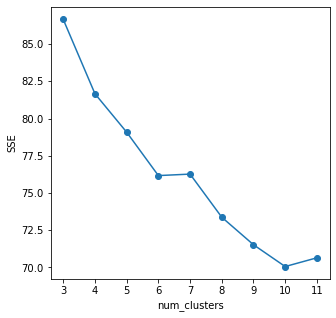

In [144]:
plt.plot(range(3,12), sse, marker='o')
plt.xlabel('num_clusters')
plt.ylabel('SSE')
#     plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
#     plt.ylim([0, 20])     # Y축의 범위: [ymin, ymax]
#     plt.figure(figsize=(6,12))
plt.show()

In [ ]:
keyword_extractor = KeywordSummarizer(tokenize = token,
    min_count=3,
    window=8,                     # cooccurrence within a sentence
    min_cooccurrence=1,
    vocab_to_idx=None,             # you can specify vocabulary to build word graph
    df=0.85,                       # PageRank damping factor
    max_iter=30,                   # PageRank maximum iteration
    verbose=False)
aaa = all_items.content.loc[insta_data.category == 0]
keywords = keyword_extractor.summarize(aaa, topk=20)

<1x100 sparse matrix of type '<class 'numpy.float32'>'
	with 100 stored elements in Compressed Sparse Row format>

In [75]:
plt.rcParams["figure.figsize"] = (20,20)

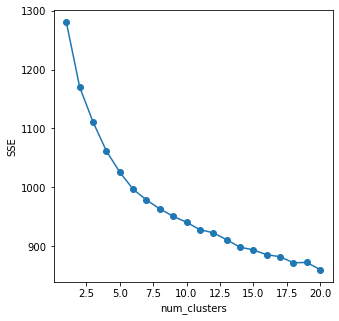

In [84]:
def elbow(x):
    global sse
    sse = []
    for i in range(1, 21):
        km_1 = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter = 600, random_state=0)
        km_1.fit(x)
        sse.append(km_1.inertia_)
    plt.plot(range(1,21), sse, marker='o')
    plt.xlabel('num_clusters')
    plt.ylabel('SSE')
#     plt.xlim([0, 5])      # X축의 범위: [xmin, xmax]
#     plt.ylim([0, 20])     # Y축의 범위: [ymin, ymax]
#     plt.figure(figsize=(6,12))
    plt.show()
    
a = all_items['wv'].to_list() 
elbow(a)

# values = []
# i = 0
# while True:
#     a = sse[i] - sse[i+1]
#     values.append(a)
#     i += 1
#     if i+2 > len(sse):
#       break 
    
# for i in range(len(values)):
#     print(f'num_{i+1}, SSE:{values[i]}')

In [81]:
a = all_items['wv'].to_list() 

In [82]:
plt.rcParams["figure.figsize"] = (5,5)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

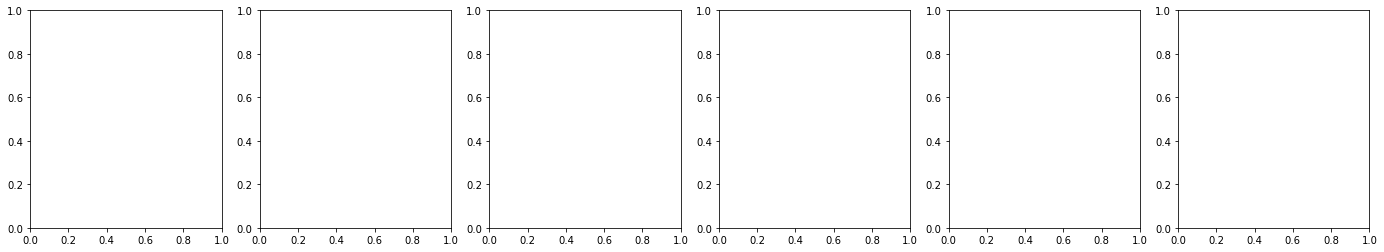

In [143]:
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = SphericalKMeans(n_clusters=n_clusters,max_iter=10,verbose=1,init='similar_cut')
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

# # visualize_silhouette([2, 3, 4, 5, 6], a)
# visualize_silhouette([7, 8, 9, 10, 11], a)
visualize_silhouette([4,5,6,7,8,9], csr)

In [56]:
# for i in range(3, 21):
#     kmeans = KMeans(n_clusters=i, init='k-means++', n_init=25, max_iter = 600, random_state=0)
#     kmeans.fit(a)
#     test['cluster'] = kmeans.labels_

#     score_samples = silhouette_samples(a , test['cluster'])
#     print(f'========{i} cluster=======')
# #     print(score_samples.shape)
# #     print(score_samples)
#     test['silhoutte_coeff'] = score_samples

#     average_score = silhouette_score(a, test['cluster'])
#     print(average_score)
#     print()

========3 cluster=======
0.055670317

========4 cluster=======
0.06960923

========5 cluster=======
0.078020014

========6 cluster=======
0.070331685

========7 cluster=======
0.062464237

========8 cluster=======
0.058176387

========9 cluster=======
0.06303673

========10 cluster=======
0.051346686

========11 cluster=======
0.04976979

========12 cluster=======
0.058389526

========13 cluster=======
0.05133174

========14 cluster=======
0.044641733

========15 cluster=======
0.043252595

========16 cluster=======
0.051976092

========17 cluster=======
0.045610376

========18 cluster=======
0.049657628

========19 cluster=======
0.042895753

========20 cluster=======
0.03781205



In [ ]:
for i in range(len(matrix)):
    matrix[i] = list(map(float,matrix[i]))
    
for i in range(len(matrix)):
    db.matrix.insert_one({f'a{i}': matrix[i]})

In [23]:
# merged_data.to_parquet(f'merged_data_{nowtime}')

In [35]:
# merged_data.to_csv('merged_data2.csv')

In [55]:
# 필수 모듈 호출
import pandas as pd
import numpy as np
import re
# Word2Vec embedding
from gensim.models import Word2Vec
from numpy import dot
from numpy.linalg import norm
import numpy as np

# 데이터 로드
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
from pyspark.sql.functions import array_contains, udf

from pymongo import MongoClient
from datetime import datetime

client = MongoClient('localhost',27017) # mongodb 27017 port
db = client.ojo_db

a = spark.read.parquet(f"hdfs://localhost:9000/data/modeldata/merged_data_{nowtime}")
matrix_data = a.toPandas()

def get_sentence_mean_vector(morphs):
    vector = []
    for i in morphs:
        try:
            vector.append(embedding_model.wv[i])
        except KeyError as e:
            pass
    try:
        return sum(vector)/len(vector)
    except IndexError as e:
        pass

def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

    
def create_matrix(wv_matrix):
    rows = []
    matrix = []
    for i in range(len(matrix_data.content_x)):
        for x in range(len(matrix_data.content_x)):
            cos_sim = dot(wv_matrix[i], wv_matrix[x])/(norm(wv_matrix[i])*norm(wv_matrix[x]))
            rows.append(cos_sim)
        matrix.append(rows)
        rows=[]
    return matrix


embedding_model = Word2Vec(matrix_data.content_x, vector_size=100, window = 2, min_count=3, workers=4, epochs=100, sg=1, seed=0)
matrix_data['wv'] = matrix_data['content_x'].map(get_sentence_mean_vector)
wv_matrix = np.asarray(matrix_data.wv)
matrix = create_matrix(wv_matrix)

for i in range(len(matrix)):
    matrix[i] = list(map(float,matrix[i]))
    
for i in range(len(matrix)):
    db.matrix.insert_one({f'a{i}': matrix[i]})

# tmp = {}

#     tmp[f'a{i}']= matrix[i]
#     db.matrix.insert_one({f'a{i}': matrix[i]})

In [10]:
for i in a.collect():
    db.insta.insert_one(i.asDict())